In [7]:
%matplotlib widget
import matplotlib.pyplot as plt 

import ipywidgets as widgets
import numpy as np
import os
import pickle
import sys, math
from glob import glob

import colour
from colour_hdri.plotting import plot_tonemapping_operator_image
colour.plotting.colour_style()
colour.utilities.describe_environment();

#import cv2 as cv
import skimage
import imageio

from astropy.io import fits
from colour.models import RGB_COLOURSPACES, RGB_luminance

colorspace = RGB_COLOURSPACES['sRGB']

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *

from matplotlib import patches
from matplotlib.collections import PatchCollection

import statmorph
from statmorph.utils import image_diagnostics

import re

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.8.5 (default, Sep  4 2020, 07:30:14)                       *
*                [GCC 7.3.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.16                                                       *
*       colour-hdri : 0.1.8                                                   *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.9.0                                                       *
*       matplotlib : 3.3.2                                                    *
*       networkx : 2.5                  

In [8]:
dataset = ['EFIFI','Nair'][1]
basedir = ['../../bf_data/EFIGI_catalog/','../../bf_data/Nair_and_Abraham_2010/'][1]
fitsdir = basedir + ['fits_temp_Jan_19/','fits_temp_Dec_28/', 'fits_temp_Feb_3/'][2]

out_dir = basedir+'out1/'

#fns_g = glob(fitsdir+"*/*g.fits")
#fns_g.sort()
fns_r = glob(fitsdir+"*/*r.fits")
fns_r.sort()
#fns_i = glob(fitsdir+"*/*i.fits")
#fns_i.sort()

eps = 1e-6

# 3. Tone map (widget)

In [4]:
from colour.plotting import (CONSTANTS_COLOUR_STYLE, artist, override_style)
from ipywidgets import GridspecLayout, Layout, Image, Button, IntSlider, FloatSlider, ToggleButtons, VBox, HBox, Box

def tonemapping_operator_generic(x,
                             a=0.125,
                             d=0.975,
                             mid_in=0.25,
                             mid_out=0.18):
    hdr_max = x.max()
    ad = a * d
    midi_pow_a  = pow(mid_in, a)
    midi_pow_ad = pow(mid_in, ad)
    hdrm_pow_a  = pow(hdr_max, a)
    hdrm_pow_ad = pow(hdr_max, ad)
    u = hdrm_pow_ad * mid_out - midi_pow_ad * mid_out
    v = midi_pow_ad * mid_out

    b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
    c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u

    x[x>hdr_max] = hdr_max
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)


def plot_tmo_plt(x,
                 a=0.125,
                 d=0.975,
                 mid_in=0.25,
                 mid_out=0.18,
                 log_scale=False,
                 cctf_encoding=CONSTANTS_COLOUR_STYLE.colour.colourspace.cctf_encoding):
    
    args = (a,d,mid_in, mid_out)
    image = tonemapping_operator_generic(x, *args)
    luminance_function = np.squeeze(tonemapping_operator_generic(np.linspace(0, 1, 200)))

    shape = image.shape
    bounding_box = [0, 1, 0, 1]

    image = np.clip(cctf_encoding(image), 0, 1)

    plt.ioff()
    fig = plt.figure()
    fig.set_size_inches(4,4)
    #self.fig = fig
    axes = fig.add_subplot()

    im = axes.imshow(image,
                     aspect=shape[0] / shape[1],
                     extent=bounding_box,
                     interpolation='nearest')

    lf, = axes.plot(np.linspace(0, 1, len(luminance_function)),
                       luminance_function,
                       color='red')

    if log_scale:
        axes.set_xlabel('$log_2$ Input Luminance')
        axes.set_xscale('log', basex=2)
        axes.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(0.5))
        axes.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.ion()
    plt.show()

In [9]:
hdulist = fits.open(fns_r[-1])
hdulist[0].data -= (hdulist[0].data.min() - eps) 
img = hdulist[0].data

In [6]:
# Initial values 
a=0.125
d=0.975
mid_in=0.25
mid_out=0.18
log_scale=False
cctf_encoding=CONSTANTS_COLOUR_STYLE.colour.colourspace.cctf_encoding

#x = stamp
x = img
lum_points = np.linspace(0, 1, 200)

args = (a,d,mid_in, mid_out)
image = tonemapping_operator_generic(x, *args)
luminance_function = np.squeeze(tonemapping_operator_generic(lum_points))

shape = image.shape
bounding_box = [0, 1, 0, 1]

image = np.clip(cctf_encoding(image), 0, 1)


#############################
plt.ioff()
fig = plt.figure()
fig.set_size_inches(4,4)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
axes = fig.add_subplot()

im = axes.imshow(image,
                 aspect=shape[0] / shape[1],
                 extent=bounding_box,
                 interpolation='nearest')

lf, = axes.plot(np.linspace(0, 1, len(luminance_function)),
                   luminance_function,
                   color='red')

if log_scale:
    axes.set_xlabel('$log_2$ Input Luminance')
    axes.set_xscale('log', basex=2)
    axes.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(0.5))
    axes.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ion()
#plt.show()


def update(change):
    if (change['new'] != change['old']):
        image = tonemapping_operator_generic(x,
                                             a=a.value,
                                             d=d.value,
                                             mid_in=mid_in.value,
                                             mid_out=mid_out.value)
        lum_fun = np.squeeze(tonemapping_operator_generic(lum_points,
                                                          a=a.value,
                                                          d=d.value,
                                                          mid_in=mid_in.value,
                                                          mid_out=mid_out.value))
        # Update tonemapped image
        im.set_data(image)
        lf.set_ydata(lum_fun)
        fig.canvas.draw_idle()

a=FloatSlider(min=0.1, max=1.5, step=0.01, continuous_update=False, description='a')
d=FloatSlider(min=0.5, max=3.0, step=0.01, continuous_update=False, description='d')
mid_in=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False, description='mid_in')
mid_out=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False, description='mid_out')

a.observe(update, names=['value']) # name of FloatSlider's trait to be observed
d.observe(update, names=['value'])
mid_in.observe(update, names=['value'])
mid_out.observe(update, names=['value'])

ui = VBox([a,d,mid_in,mid_out])

#mapped_image = Box(fig.canvas)
the_box = HBox([fig.canvas, ui])
the_box

In [156]:
plt.savefig("PGC0013406_1.49_1.66_0.95_0.29.png")

## TM curves applied to raw images

In [935]:
def get_values(control):
    return {ctr.description:ctr.value for ctr in control}

tmo_params = get_values(ui.children)

NameError: name 'ui' is not defined

In [934]:
tmo_params

{'a': 0.125, 'd': 0.975, 'mid_in': 0.25, 'mid_out': 0.18}

In [5]:
too_deem = [2365, 8225, 9406, 10117, 13406]

In [6]:
gids = np.asarray(gids)
too_deem_fns=[fns_r[np.where(gids==target_gid)[0].squeeze()] for target_gid in too_deem]

NameError: name 'gids' is not defined

In [161]:
import os

try:
    out_dir = basedir+"{}_{}_{}_{}/".format(*tmo_params.values())
    os.mkdir(out_dir)
except:
    pass

In [150]:
sub_rows = 3
fig, axs = plt.subplots(sub_rows, sub_rows)
fig.set_size_inches(12,12)
axs = axs.ravel()
for ax, fn in zip(axs, too_deem_fns):
    img_name = fn.split("/")[-2]
    hdulist = fits.open(fn)

    # Ensure pixel values are positive
    hdulist[0].data -= (hdulist[0].data.min() - eps) 
    hdulist[0].data = tonemapping_operator_generic(hdulist[0].data, **tmo_params)
    #hdulist[0].data[hdulist[0].data < 10*eps] = eps
    mask, img, mask_new = mask_utils.gmm_mask(hdulist,
                                   max_n_comp=20, 
                                   sig_factor=2.0, 
                                   verbose=False, 
                                   do_plot=False,
                                   npix_min=50)
    ax.imshow(np.log10(img))
    ax.imshow(mask, alpha=0.5)
    #mask_new = mask_hull(mask, ax)
    ax.text(0.05,0.05, img_name, transform=ax.transAxes)
    pickle.dump(mask_new, open(out_dir+f"{img_name}_mask.pickle", "wb"))
plt.tight_layout()
plt.savefig(out_dir+f"deem.png", dpi=144)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))


In [933]:
import ipywidgets as widgets
from ipywidgets import FloatSlider
from IPython.display import display

from astrobf.utils import tmo_utils 

def tonemapping_operator_generic_interactive(image,
                                             a=0.125,
                                             d=0.975,
                                             mid_in=0.25,
                                             mid_out=0.18):
    args = (a,d,mid_in, mid_out)
    return tmo_utils.plot_tonemapping_operator_image(
        tmo_utils.tonemapping_operator_generic(image, *args),
        np.squeeze(tmo_utils.tonemapping_operator_generic(np.linspace(0, 1, 512), *args)),
        title='Generic Tonemapping Operator')
    

tmo_widget = widgets.interactive(
            tonemapping_operator_generic_interactive,
            image=widgets.fixed(stamp),
            a=FloatSlider(min=0.1, max=1.5, step=0.01, continuous_update=False),
            d=FloatSlider(min=0.5, max=3.0, step=0.01, continuous_update=False),
            mid_in=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False),
            mid_out=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False))

NameError: name 'stamp' is not defined

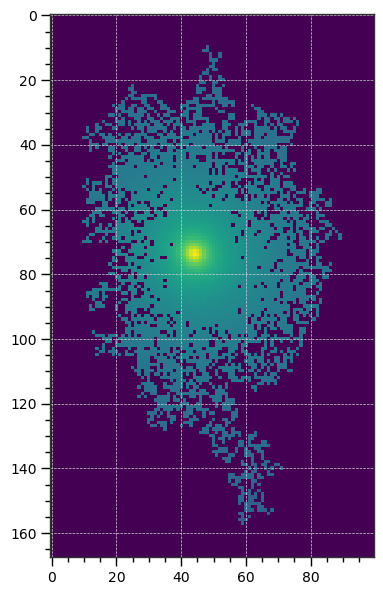

In [9]:
# Get the data out.
mapped = tmo_widget.result

plt.imshow(mapped)
plt.show()

In [ ]:
# get current tmo parameters